# Tutorial on genotype imputation

This notebook showcase a few examples of the software [MendelImpute.jl](https://github.com/biona001/MendelImpute) (a work in progress).

## Package installation

In [1]:
# machine information for reproducibility
versioninfo()

Julia Version 1.2.0
Commit c6da87ff4b (2019-08-20 00:03 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


In [2]:
#load necessary packages, install them if you don't have it
using Revise
using MendelImpute
using VCFTools
using GeneticVariation
using Random
using SparseArrays
using Plots

In [3]:
]add https://github.com/biona001/MendelImpute

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/biona001/MendelImpute`
  Updating git-repo `https://github.com/biona001/MendelImpute`
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [4]:
]add https://github.com/OpenMendel/VCFTools.jl

  Updating git-repo `https://github.com/OpenMendel/VCFTools.jl`
  Updating git-repo `https://github.com/OpenMendel/VCFTools.jl`
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


# Simulate sample data

We simulate 1000 reference haplotypes each with 3000 SNPs. Then we use this haplotype matrix to construct a genotype matrix matrix with 100 samples and 3000 SNPs. Each person's genotype are separated into 1-5 chunks, where 2 haplotypes are chosen with replacement to fill the chunk. The genotype matrix are randomly masked to generate the missing values. 

The result is stored in 3 files:

+ **`haplo_ref.vcf.gz`**: haplotype reference files
+ **`target.vcf.gz`**: complete genotype information
+ **`target_masked.vcf.gz`**: incomplete genotype information (10% are missing)

In [5]:
# 1000 haplotypes each with 3000 SNPs, 100 imputation targets 
snps   = 3000
haps   = 1000
people = 100

# simulate full haplotype and genotype matrix
@time H = simulate_markov_haplotypes(snps, haps)
@time X = simulate_genotypes(H, people)

# randomly mask entries
Random.seed!(2020)
missingprop = 0.01
@time Xm = ifelse.(rand(snps, people) .< missingprop, missing, X)

# write 3 files to disk
@time make_refvcf_file(H, vcffilename="./data/haplo_ref.vcf.gz")
@time make_tgtvcf_file(X, vcffilename="./data/target.vcf.gz")
@time make_tgtvcf_file(Xm, vcffilename="./data/target_masked.vcf.gz")

  0.063884 seconds (187.16 k allocations: 9.739 MiB, 9.75% gc time)
  0.409242 seconds (1.63 M allocations: 83.725 MiB, 5.37% gc time)
  0.259699 seconds (841.34 k allocations: 51.352 MiB, 7.00% gc time)
  2.524999 seconds (12.29 M allocations: 617.290 MiB, 8.32% gc time)
  0.279562 seconds (570.88 k allocations: 28.612 MiB, 1.58% gc time)
  0.142773 seconds (24.05 k allocations: 1.265 MiB)


# Example: Import, manipulate, and visual data

OpenMendel's `VCFTools.jl` allow us to import VCF files directly as numeric matrix:

In [6]:
# read target data that needs imputation
Xm = convert_gt(Float64, "./data/target_masked.vcf.gz")

100×3000 Array{Union{Missing, Float64},2}:
 2.0       1.0       1.0       1.0       …  1.0   missing  2.0  2.0       2.0
 0.0       0.0       0.0       0.0          0.0  1.0       1.0   missing  2.0
 1.0       1.0       0.0       2.0          0.0  2.0       1.0  1.0       1.0
 0.0       0.0       0.0       1.0          0.0  0.0       1.0  1.0       1.0
 0.0       0.0       1.0       1.0          2.0  1.0       0.0  0.0       0.0
 0.0       1.0       2.0       2.0       …  2.0  2.0       2.0  1.0       1.0
 1.0       1.0        missing  1.0          2.0  2.0       2.0  2.0       0.0
 1.0       2.0       2.0       2.0          1.0  2.0       2.0  2.0       2.0
 1.0       0.0       0.0       0.0          1.0  2.0       2.0  0.0       0.0
 2.0       1.0       1.0       2.0          1.0  1.0       1.0  2.0       2.0
 0.0       1.0       0.0       0.0       …  1.0  1.0       1.0  2.0       2.0
 0.0       0.0       1.0       1.0          1.0  1.0       1.0  0.0       1.0
 0.0       1.0       

Typical matrix operations are permitted in the usual way 

In [7]:
Xm[1:10, 1:10] * rand(10)

10-element Array{Union{Missing, Float64},1}:
 6.946557949192465  
 0.19495420229215998
 7.188284556863996  
 3.360903399086474  
 1.5682835552236711 
 4.3672346475523245 
  missing           
 6.253102837340199  
 4.583905157856268  
 6.5177211203936345 

Visualize missingness (each dot is a missing value):

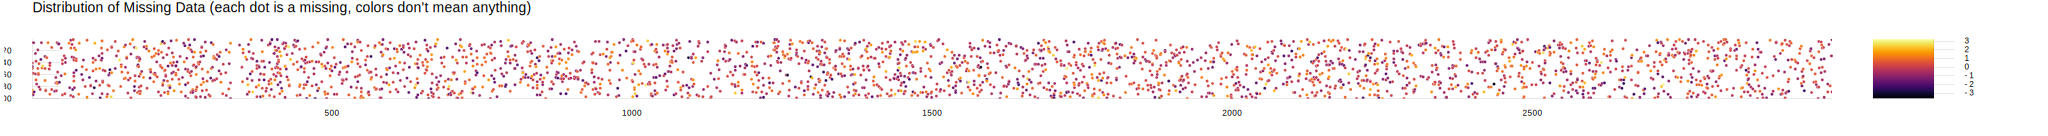

In [8]:
Xm_missing_idx = randn(size(Xm)) .* sparse(ismissing.(Xm))
spy(Xm_missing_idx, size=(3000,200), 
    title="Distribution of Missing Data (each dot is a missing, colors don't mean anything)", 
    title_location=:left, markersize = 20)

# Okay, let's run imputation!

Given a reference panel, we run 1 command:

In [9]:
# impute
tgtfile = "./data/target_masked.vcf.gz"
reffile = "./data/haplo_ref.vcf.gz"
outfile = "./data/imputed_target.vcf.gz"
width   = 400
@time phase(tgtfile, reffile, impute=true, outfile = outfile, width = width);

  6.605582 seconds (18.73 M allocations: 1.108 GiB, 8.92% gc time)


The result can be outputed as uncompressed `.vcf` or compressed `.vcf.gz` formats. 

## Import imputed result

In [10]:
X_mendel = convert_gt(Float64, outfile)

100×3000 Array{Union{Missing, Float64},2}:
 2.0  1.0  1.0  1.0  0.0  0.0  2.0  2.0  …  0.0  1.0  1.0  0.0  2.0  2.0  2.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  1.0  1.0  1.0  2.0
 1.0  1.0  0.0  2.0  2.0  0.0  0.0  2.0     1.0  1.0  0.0  2.0  1.0  1.0  1.0
 0.0  0.0  0.0  1.0  2.0  1.0  1.0  1.0     1.0  0.0  0.0  0.0  1.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0     2.0  2.0  2.0  1.0  0.0  0.0  0.0
 0.0  1.0  2.0  2.0  2.0  1.0  1.0  0.0  …  1.0  1.0  2.0  2.0  2.0  1.0  1.0
 1.0  1.0  2.0  1.0  0.0  0.0  1.0  0.0     1.0  1.0  2.0  2.0  2.0  2.0  0.0
 1.0  2.0  2.0  2.0  1.0  1.0  0.0  1.0     0.0  0.0  1.0  2.0  2.0  2.0  2.0
 1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0     1.0  1.0  1.0  2.0  2.0  0.0  0.0
 2.0  1.0  1.0  2.0  2.0  1.0  1.0  1.0     2.0  1.0  1.0  1.0  1.0  2.0  2.0
 0.0  1.0  0.0  0.0  1.0  2.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  2.0  2.0
 0.0  0.0  1.0  1.0  1.0  2.0  2.0  1.0     1.0  2.0  1.0  1.0  1.0  0.0  1.0
 0.0  1.0  1.0  1.0  

## Compare with true data

In [11]:
# import complete genotype info
X_true = convert_gt(Float64, "./data/target.vcf.gz")
error_rate = sum(X_true .!= X_mendel) / snps / people

0.00044333333333333334

## Visualize where did our imputation went wrong

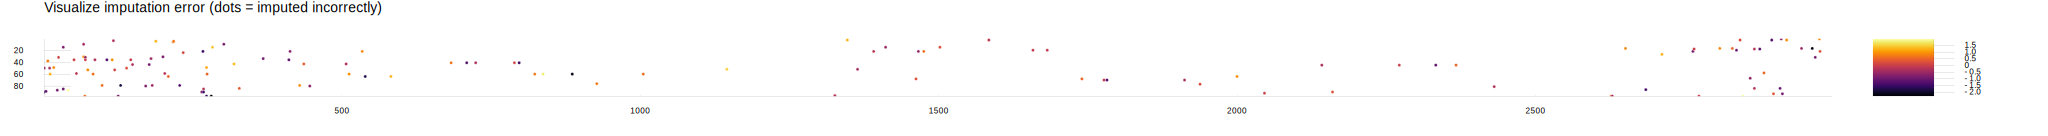

In [12]:
disagreeing_entries = randn(size(X_true)) .* sparse(X_true .!= X_mendel)
Plots.spy(disagreeing_entries, size=(3000,200), title="Visualize imputation error (dots = imputed incorrectly)", title_location=:left, markersize = 20)

# Conclusion

+ We present an analysis pipeline that supports importing, manipulating, and visualizing raw genotype data
+ Genotype data (imputation target) does **not** have be be pre-phased. 